# Robust PCA (RPCA) using ADMM on the MNIST Dataset

In this notebook, we apply **Robust Principal Component Analysis (RPCA)** to MNIST images under artificial corruption.

We arrange vectorized images as columns of a data matrix

$$
M \in \mathbb{R}^{784 \times N}
$$

and solve the following optimization problem:

$$
\min_{L,S} \ \|L\|_* + \lambda \|S\|_1 
\quad \text{s.t.} \quad M = L + S,
$$

where:
- $L$ is **low-rank**, capturing shared structure,
- $S$ is **sparse**, capturing corruptions or outliers
- $N$ is the **number** of image samples used in the experiment.


We then visualize, for a subset of samples:
- the **corrupted images**,
- the **recovered low-rank components**,
- the **recovered sparse components**,

as well as the **ADMM convergence curve**.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from robust_pca_admm.admm_rpca import rpca_admm

In [3]:
#data directory
DATA_DIR = Path("../data/dataset_mn")

#files expected inside DATA_DIR
IMAGES_FILE = DATA_DIR / "train-images.idx3-ubyte"

SEED = 0
N_SAMPLES = 200 #number of MNIST images used to form the data matrix M, for speed
CORRUPTION_P = 0.10 #fraction of pixels corrupted
CORRUPTION_MODE = "s&p" #salt & pepper noise (large-magnitude sparse outliers)
N_SHOW = 8

#ADMM settings
RHO = 1.0 #ADMM penalty parameter (fixed across experiments)
MAX_ITER = 1500
TOL = 1e-5
VERBOSE = False

rng = np.random.default_rng(SEED)

print("Images file exists:", IMAGES_FILE.exists())

Images file exists: True


In [4]:
def load_mnist_images_idx(path: Path) -> np.ndarray:
    """
    Load MNIST images from IDX3-UBYTE file.
    Returns array of shape (N, 28, 28) in float64 scaled to [0,1].
    """
    with open(path, "rb") as f:
        magic = int.from_bytes(f.read(4), "big")
        if magic != 2051:
            raise ValueError(f"Not a valid MNIST images IDX file (magic={magic}).")

        n_images = int.from_bytes(f.read(4), "big")
        n_rows = int.from_bytes(f.read(4), "big")
        n_cols = int.from_bytes(f.read(4), "big")

        data = np.frombuffer(f.read(), dtype=np.uint8)
        images = data.reshape(n_images, n_rows, n_cols).astype(np.float64) / 255.0

    return images

## Clean MNIST samples
Examples of uncorrupted MNIST images used as input to the RPCA experiment.


Loaded images: (60000, 28, 28) float64 min/max: 0.0 1.0


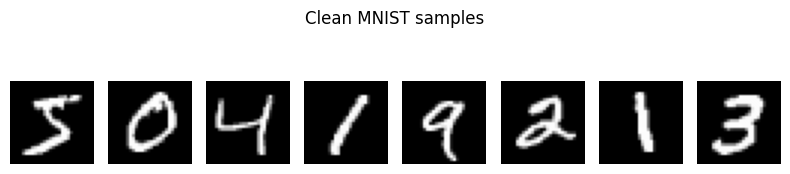

In [5]:
#load MNIST training images from the raw IDX file (60000 samples)
images_all = load_mnist_images_idx(IMAGES_FILE)
print("Loaded images:", images_all.shape, images_all.dtype, "min/max:", images_all.min(), images_all.max())

#display a few clean images
plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(images_all[i], cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.suptitle("Clean MNIST samples")
plt.tight_layout()
plt.show()

## Subsampling the dataset

To reduce computational cost, we randomly select a subset of $N$ images from the MNIST training set.
This subset is used to form the data matrix $M \in \mathbb{R}^{784 \times N}$ for the RPCA experiment.



In [6]:
idx = np.arange(len(images_all))
rng.shuffle(idx)
idx = idx[:N_SAMPLES]

images = images_all[idx] #shape (N, 28, 28)

print("Subset:", images.shape)

Subset: (200, 28, 28)


## Corrupted MNIST samples

The images are corrupted using salt-and-pepper noise, where a fraction $p$ of pixels
is randomly set to either 0 or 1. This type of corruption is sparse and non-Gaussian,
making it suitable for evaluation with RPCA.

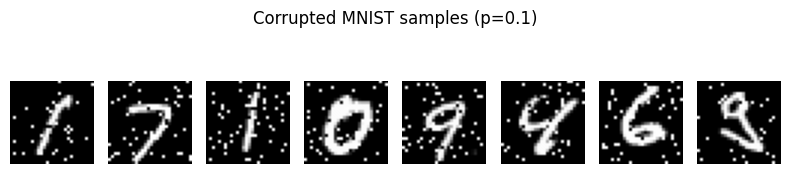

In [25]:
def corrupt_salt_pepper(images: np.ndarray, p: float, rng: np.random.Generator) -> np.ndarray:
    """
    Salt & pepper corruption for grayscale images in [0,1].
    With prob p per pixel, set to 0 or 1.
    """
    Xc = images.copy()
    mask = rng.random(Xc.shape) < p
    salt = rng.random(Xc.shape) < 0.5
    Xc[mask & salt] = 1.0
    Xc[mask & ~salt] = 0.0
    return Xc


def corrupt_random(images: np.ndarray, p: float, rng: np.random.Generator) -> np.ndarray:
    """
    Replace a fraction p of pixels with random values in [0,1].
    """
    Xc = images.copy()
    mask = rng.random(Xc.shape) < p
    Xc[mask] = rng.random(np.count_nonzero(mask))
    return Xc


def corrupt(images: np.ndarray, p: float, mode: str, rng: np.random.Generator) -> np.ndarray:
    if mode == "s&p":
        return corrupt_salt_pepper(images, p, rng)
    if mode == "random":
        return corrupt_random(images, p, rng)
    raise ValueError("mode must be 's&p' or 'random'")


images_corrupt = corrupt(images, CORRUPTION_P, CORRUPTION_MODE, rng)

#show a few corrupted images
plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(images_corrupt[i], cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.suptitle(f"Corrupted MNIST samples (p={CORRUPTION_P})")
plt.tight_layout()
plt.show()

## Experimental setup

- **Dataset:** MNIST (training set)
- **Image size:** $28 \times 28$ (vectorized to 784)
- **Number of samples:** $N = 200$
- **Corruption type:** salt-and-pepper noise
- **Corruption probability:** $p = 0.1$

### ADMM parameters

- $\lambda = \dfrac{1}{\sqrt{\max(m,n)}}$
- $\rho = 1.0$
- **Tolerance:** $10^{-5}$
- **Maximum iterations:** 1500

***Parameter choices***  
The salt-and-pepper corruption is intentionally chosen to match the assumptions of Robust PCA, namely sparse, non-Gaussian outliers.  
The regularization parameter $ \lambda = 1 / \sqrt{\max(m,n)} $ follows the standard theoretical recommendation for RPCA and provides a balanced trade-off between low-rank and sparse components.  
The ADMM penalty parameter $ \rho $ is set to a fixed value for simplicity, as convergence was observed to be stable without adaptive tuning.  
The stopping tolerance is chosen to ensure accurate satisfaction of the constraint $ M = L + S $ while keeping the computational cost reasonable.


## Construct the data matrix $M$
Each vectorized image is placed as a column of $M \in \mathbb{R}^{784 \times N}$.

In [8]:
#stack each flattened image as a COLUMN: M shape (784, N)
M = images_corrupt.reshape((N_SAMPLES, -1)).T
print("M shape:", M.shape)

M shape: (784, 200)


## RPCA using ADMM
We solve $\min_{L,S}\ \|L\|_* + \lambda\|S\|_1 \ \text{s.t.}\ M = L + S$ using ADMM, where $L$ is low-rank and $S$ is sparse.

In [9]:
L, S, info = rpca_admm(M, rho=RHO, max_iter=MAX_ITER, tol=TOL, verbose=VERBOSE)

print("Converged:", info.converged)
print("Iterations:", info.iters)
print("Final relative primal residual:", info.residuals[-1])

rank_L = np.linalg.matrix_rank(L)
sparsity_S = np.mean(np.abs(S) > 1e-6)
print("rank(L):", rank_L)
print("sparsity(S):", sparsity_S)

Converged: True
Iterations: 470
Final relative primal residual: 9.982833066718684e-06
rank(L): 37
sparsity(S): 0.40323341836734694


***RPCA solution diagnostics***  

The ADMM algorithm converges successfully, reaching a small relative primal residual (around $10^{-5}$), which shows that the reconstruction constraint $M = L + S$ is satisfied to high accuracy.

The recovered low-rank component has rank 37, which is much smaller than the original data dimension (784). This indicates that the main structure of the data can be well represented in a low-dimensional subspace.

The sparse component (sparsity level 40%) captures the salt-and-pepper noise added to the images, as well as sharp image details such as digit edges, which appear as high-frequency patterns.



## RPCA decomposition results
We visualize the corrupted input alongside the recovered low-rank component $L$ and the sparse corruption component $S$.
For clarity, we display $|S|$ to highlight corruption magnitude.

In [34]:
def show_triplets(images_corrupt: np.ndarray, L: np.ndarray, S: np.ndarray, n_show: int = 8):
    """
    Show (corrupted, low-rank L, sparse |S|) for the first n_show samples.
    images_corrupt: (N, 28, 28)
    L, S: (784, N)
    """
    n_show = min(n_show, images_corrupt.shape[0], L.shape[1], S.shape[1])

    #shared scaling for |S| across shown samples (nice for consistent contrast)
    vmax_S = np.abs(S[:, :n_show]).max() + 1e-12

    fig, axs = plt.subplots(n_show, 3, figsize=(4, 1.2 * n_show))

    #if n_show == 1, axs is 1D (make it 2D for consistent indexing)
    if n_show == 1:
        axs = np.expand_dims(axs, axis=0)

    for i in range(n_show):
        corrupted_img = images_corrupt[i]
        lowrank_img = L[:, i].reshape(28, 28)
        sparse_img = S[:, i].reshape(28, 28)

        axs[i, 0].imshow(corrupted_img, cmap="gray", vmin=0, vmax=1)
        axs[i, 1].imshow(lowrank_img, cmap="gray", vmin=0, vmax=1)
        axs[i, 2].imshow(np.abs(sparse_img), cmap="gray", vmin=0, vmax=vmax_S)

        for j in range(3):
            axs[i, j].axis("off")

        if i == 0:
            axs[i, 0].set_title("Corrupted")
            axs[i, 1].set_title("Low-rank (L)")
            axs[i, 2].set_title("Sparse (|S|)")

    plt.tight_layout()
    plt.show()


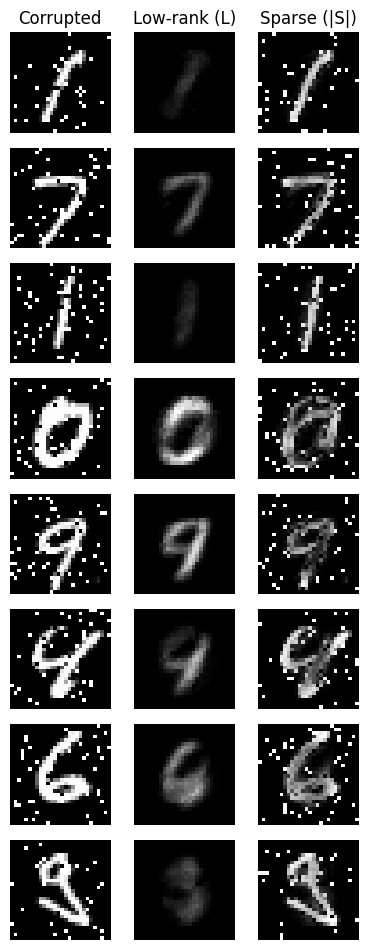

In [35]:
show_triplets(images_corrupt, L, S, n_show=N_SHOW)

## PCA baseline (low-rank approximation)

To provide a baseline comparison, we compute a standard PCA reconstruction of the corrupted data matrix

$$
M.
$$ 

PCA approximates the data matrix using a rank-$k$ low-rank approximation based on the leading singular values, but it does not explicitly model sparse corruptions.



In [ ]:
def pca_lowrank(M: np.ndarray, k: int) -> np.ndarray:
    """
    PCA baseline: best rank-k approximation of M (in Frobenius norm)
    using truncated SVD: M_k = U[:, :k] diag(s[:k]) Vt[:k, :].
    """
    U, s, Vt = np.linalg.svd(M, full_matrices=False)
    return (U[:, :k] * s[:k]) @ Vt[:k, :]

In [ ]:
#K: rank of the PCA approximation (number of principal components)
#we choose K=20 as a moderate low-rank baseline:
# -comparable in scale to the effective rank of the RPCA solution,
# -sufficient to capture the overall digit structure,
# -but small enough to avoid fitting sparse salt-and-pepper noise,
#which PCA cannot explicitly model

K = 20 
L_pca = pca_lowrank(M, k=K)

## PCA vs RPCA (visual comparison)

Since PCA explicitly minimizes reconstruction error, scalar error metrics are not directly comparable to RPCA. We therefore focus on qualitative visual comparison, which better reflects the ability to separate sparse corruption from underlying structure.

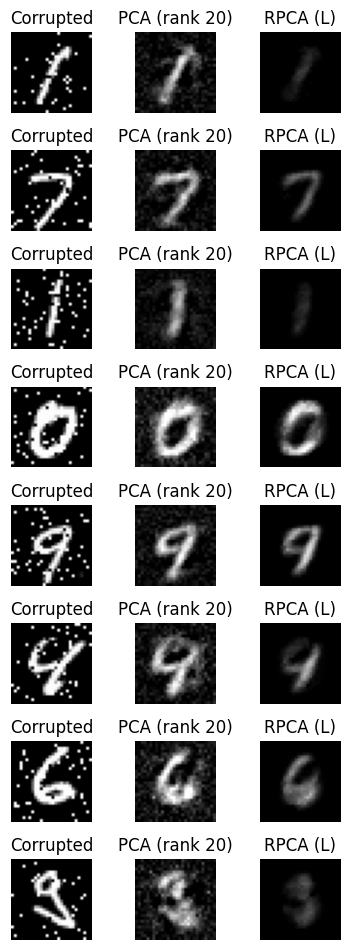

In [36]:
def show_pca_vs_rpca(images_corrupt: np.ndarray, L_rpca: np.ndarray, L_pca: np.ndarray, n_show: int = 8):
    """
    Show: Corrupted | PCA low-rank | RPCA low-rank
    for the first n_show samples.
    """
    n_show = min(n_show, images_corrupt.shape[0])
    fig, axs = plt.subplots(n_show, 3, figsize=(4, 1.2 * n_show))

    for i in range(n_show):
        corrupted_img = images_corrupt[i]
        pca_img = L_pca[:, i].reshape(28, 28)
        rpca_img = L_rpca[:, i].reshape(28, 28)

        axs[i, 0].imshow(corrupted_img, cmap="gray", vmin=0, vmax=1)
        axs[i, 0].set_title("Corrupted")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(pca_img, cmap="gray", vmin=0, vmax=1)
        axs[i, 1].set_title(f"PCA (rank {K})")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(rpca_img, cmap="gray", vmin=0, vmax=1)
        axs[i, 2].set_title("RPCA (L)")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

show_pca_vs_rpca(images_corrupt, L, L_pca, n_show=N_SHOW)


PCA reconstructs the data using a low-rank approximation but treats sparse corruptions as part of the signal.
As a result, the recovered images remain affected by noise.

In contrast, RPCA explicitly models sparse outliers and successfully separates them from the underlying low-rank structure.
The recovered low-rank component $L$ captures the digit shape more clearly, demonstrating the robustness of RPCA to sparse, non-Gaussian noise.


## ADMM convergence

We check the **relative primal residual**
$$
r_k = \frac{\|M - L_k - S_k\|_F}{\|M\|_F},
$$
which measures how well the constraint $$ M = L + S $$ is satisfied over iterations.



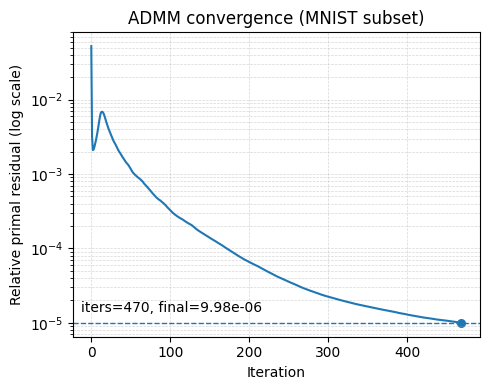

In [37]:
plt.figure(figsize=(5, 4))
plt.plot(info.residuals)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Relative primal residual (log scale)")
plt.title("ADMM convergence (MNIST subset)")
plt.axhline(TOL, linestyle="--", linewidth=1)
plt.scatter(len(info.residuals) - 1, info.residuals[-1], s=30)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

plt.text(0.02, 0.08, f"iters={info.iters}, final={info.residuals[-1]:.2e}",
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


## Results summary

| Metric | Value |
|------|------|
| Converged | Yes |
| Iterations | 470 |
| Final relative residual | $$9.98 \times 10^{-6}$$ |


## Interpretation of results

The corrupted images contain sparse salt-and-pepper noise. Salt-and-pepper noise is used because it is sparse: only a small fraction of pixels is corrupted, which matches the assumptions of Robust PCA.
The low-rank component $L$ captures the shared structure across samples, resulting in smoother and blurred digit representations.  
The sparse component $|S|$ highlights both the artificial noise and high-frequency details such as digit edges.  

Despite this separation, the decomposition satisfies $$M \approx L + S$$, as confirmed by the small reconstruction residual.


## ADMM Convergence Behavior

The plot shows the evolution of the relative primal residual

$
r_k = \frac{\|M - L_k - S_k\|_F}{\|M\|_F},
$

which measures how well the constraint $ M = L + S $ is satisfied at each iteration.

During the first iterations, the residual shows a non-monotonic behavior. This is typical for ADMM and is caused by the alternating updates of the low-rank component $L$ and the sparse component $S$, which may temporarily improve one subproblem at the expense of the other.

After this initial phase, the residual decreases steadily over several orders of magnitude, indicating stable convergence toward a consistent decomposition. The algorithm converges after 470 iterations, reaching a final relative primal residual of approximately $10^{-5}$, which confirms that the constraint $ M = L + S $ is well satisfied .

Overall, the experiment confirms that ADMM-based RPCA successfully separates low-rank structure from sparse corruption on MNIST data and converges reliably under the chosen parameter settings.
It is worth noting that RPCA is designed to handle sparse corruption, and its performance may degrade under dense or structured noise patterns.

